# DATASET- FDMB 5000 movies Dataset

In [1]:
# importation of libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from wordcloud import WordCloud
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from surprise import SVD, KNNBasic, SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, precision_score, recall_score, f1_score,accuracy_score
import time

/Users/mac/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.8' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
#Load the dataset
credits = pd.read_csv('tmdb_5000_credits.csv')
movie = pd.read_csv('tmdb_5000_movies.csv')

# DATA PRE_PROCESSING

In [3]:
#Pre-process the Dataset
credits = credits.rename(columns={'movie_id': 'id'})
movies = movie.merge(credits, on='id')

In [4]:
def get_text(text, obj='name'):
    text = literal_eval(text)
    
    if len(text) == 1:
        for i in text:
            return i[obj]
    else:
        s = []
        for i in text:
            s.append(i[obj])
        return ', '.join(s)
    
movies['genres'] = movies['genres'].apply(get_text)
movies['production_companies'] = movies['production_companies'].apply(get_text)
movies['production_countries'] = movies['production_countries'].apply(get_text)
movies['crew'] = movies['crew'].apply(get_text)
movies['spoken_languages'] = movies['spoken_languages'].apply(get_text)
movies['keywords'] = movies['keywords'].apply(get_text)

# New columns
movies['characters'] = movies['cast'].apply(get_text, obj='character')
movies['actors'] = movies['cast'].apply(get_text)

movies.drop('cast', axis=1, inplace=True)
movies = movies[~movies['original_title'].duplicated()]
movies = movies.reset_index(drop=True)

In [5]:
# Display the first 5 rows of the dataset
movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,spoken_languages,status,tagline,title_x,vote_average,vote_count,title_y,crew,characters,actors
0,237000000,"Action, Adventure, Fantasy, Science Fiction",http://www.avatarmovie.com/,19995,"culture clash, future, space war, space colony...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"Ingenious Film Partners, Twentieth Century Fox...",...,"English, Español",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"Stephen E. Rivkin, Rick Carter, Christopher Bo...","Jake Sully, Neytiri, Dr. Grace Augustine, Col....","Sam Worthington, Zoe Saldana, Sigourney Weaver..."
1,300000000,"Adventure, Fantasy, Action",http://disney.go.com/disneypictures/pirates/,285,"ocean, drug abuse, exotic island, east india t...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"Walt Disney Pictures, Jerry Bruckheimer Films,...",...,English,Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"Dariusz Wolski, Gore Verbinski, Jerry Bruckhei...","Captain Jack Sparrow, Will Turner, Elizabeth S...","Johnny Depp, Orlando Bloom, Keira Knightley, S..."
2,245000000,"Action, Adventure, Crime",http://www.sonypictures.com/movies/spectre/,206647,"spy, based on novel, secret agent, sequel, mi6...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"Columbia Pictures, Danjaq, B24",...,"Français, English, Español, Italiano, Deutsch",Released,A Plan No One Escapes,Spectre,6.3,4466,Spectre,"Thomas Newman, Sam Mendes, Anna Pinnock, John ...","James Bond, Blofeld, Madeleine, M, Lucia, Q, M...","Daniel Craig, Christoph Waltz, Léa Seydoux, Ra..."
3,250000000,"Action, Crime, Drama, Thriller",http://www.thedarkknightrises.com/,49026,"dc comics, crime fighter, terrorist, secret id...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"Legendary Pictures, Warner Bros., DC Entertain...",...,English,Released,The Legend Ends,The Dark Knight Rises,7.6,9106,The Dark Knight Rises,"Hans Zimmer, Charles Roven, Christopher Nolan,...","Bruce Wayne / Batman, Alfred Pennyworth, James...","Christian Bale, Michael Caine, Gary Oldman, An..."
4,260000000,"Action, Adventure, Science Fiction",http://movies.disney.com/john-carter,49529,"based on novel, mars, medallion, space travel,...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,Walt Disney Pictures,...,English,Released,"Lost in our world, found in another.",John Carter,6.1,2124,John Carter,"Andrew Stanton, Andrew Stanton, John Lasseter,...","John Carter, Dejah Thoris, Sola, Tars Tarkas, ...","Taylor Kitsch, Lynn Collins, Samantha Morton, ..."


In [6]:
# Check for missing values
movies.isna().sum()

budget                     0
genres                     0
homepage                3089
id                         0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title_x                    0
vote_average               0
vote_count                 0
title_y                    0
crew                       0
characters                 0
actors                     0
dtype: int64

In [7]:
movies['runtime'] = movies['runtime'].fillna(0)
movies['tagline'] = movies['tagline'].fillna('')

movies.dropna(inplace=True)

In [8]:
# Get basic statistics of the dataset
movies.describe()

,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,1.712000e+03,1712.000000,1712.000000,1.712000e+03,1712.000000,1712.000000,1712.000000
mean,4.196824e+07,67290.872079,32.618629,1.395772e+08,108.183995,6.244685,1194.382593
std,5.260389e+07,91578.666247,46.120602,2.315356e+08,19.781374,1.067383,1729.008700
min,0.000000e+00,11.000000,0.010909,0.000000e+00,0.000000,0.000000,0.000000
25%,4.500000e+06,8404.250000,8.830353,2.765780e+06,95.000000,5.700000,135.000000
50%,2.200000e+07,27578.500000,21.813376,4.978986e+07,105.000000,6.300000,524.500000
75%,6.000000e+07,76343.000000,42.776643,1.634997e+08,120.000000,6.900000,1472.500000
max,3.800000e+08,426469.000000,875.581305,2.787965e+09,201.000000,8.400000,13752.000000


In [9]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1712 entries, 0 to 4799
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                1712 non-null   int64  
 1   genres                1712 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    1712 non-null   int64  
 4   keywords              1712 non-null   object 
 5   original_language     1712 non-null   object 
 6   original_title        1712 non-null   object 
 7   overview              1712 non-null   object 
 8   popularity            1712 non-null   float64
 9   production_companies  1712 non-null   object 
 10  production_countries  1712 non-null   object 
 11  release_date          1712 non-null   object 
 12  revenue               1712 non-null   int64  
 13  runtime               1712 non-null   float64
 14  spoken_languages      1712 non-null   object 
 15  status               

# DATASET VISUALISATION/EXPLORATION

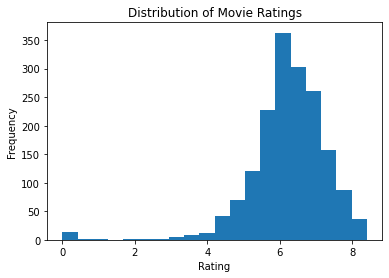

In [10]:
# Visualize the distribution of movie ratings
#sns.distplot(movies['vote_average'], bins=20, kde=False)
plt.hist(movies['vote_average'], bins=20)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()


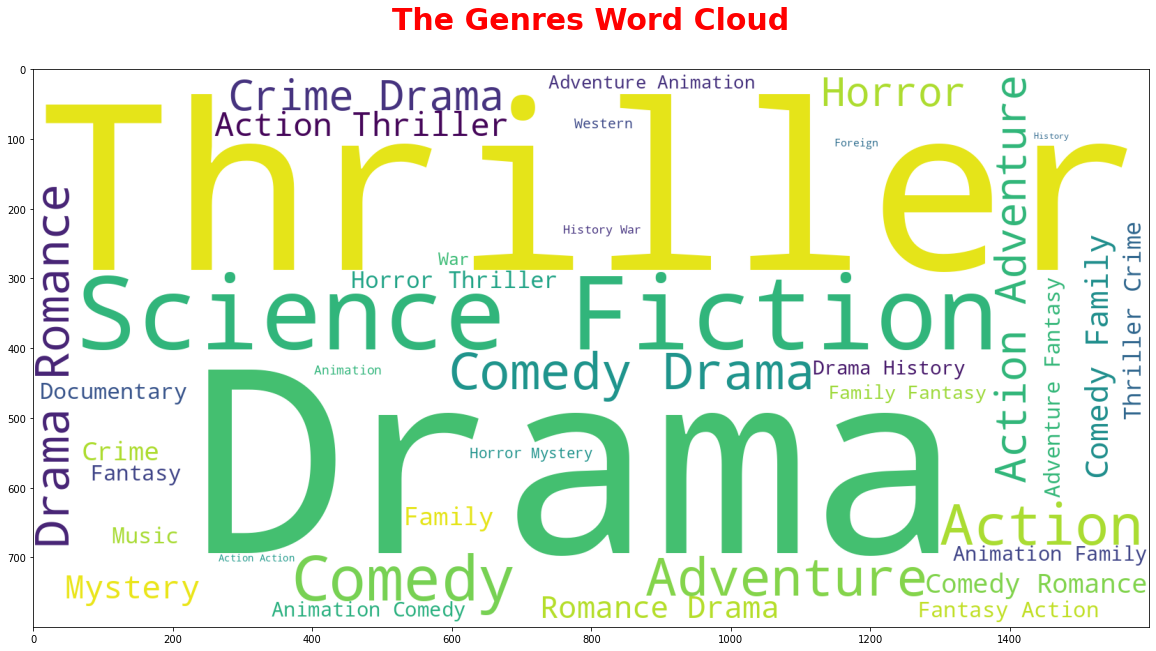

In [11]:
plt.figure(figsize=(20,20))
plt.title('The Genres Word Cloud\n', fontsize=30, weight=600, color='red')
wc = WordCloud(max_words=1000, min_font_size=10,
                height=800,width=1600,background_color="white").generate(' '.join(movies['genres']))

plt.imshow(wc)

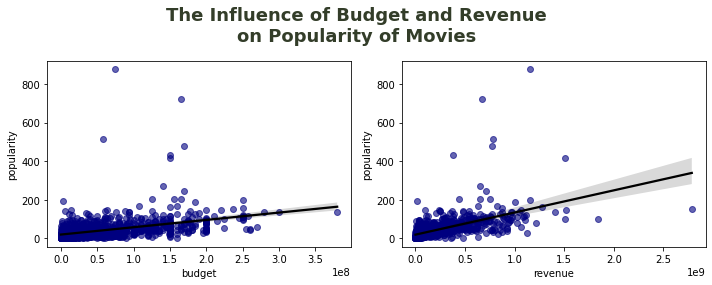

In [12]:
df_plot = movies[(movies['budget'] != 0) & (movies['revenue'] != 0)]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

plt.suptitle('The Influence of Budget and Revenue\non Popularity of Movies', fontsize=18, weight=600, color='#333d29')
for i, col in enumerate(['budget', 'revenue']):
    sns.regplot(data=df_plot, x=col, y='popularity',
                scatter_kws={"color": 'navy', "alpha": 0.6}, line_kws={"color": "black"}, ax=axes[i])

plt.tight_layout()

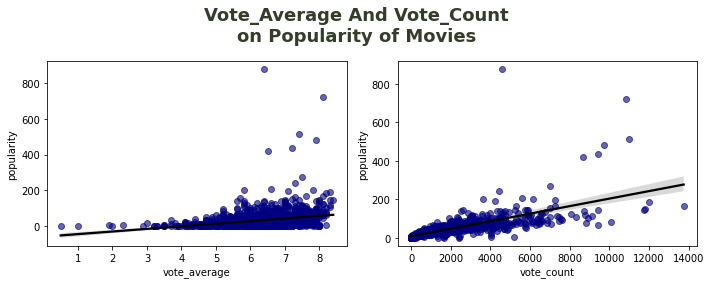

In [13]:
df_plot = movies[(movies['vote_average'] != 0) & (movies['vote_count'] != 0)]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

plt.suptitle('Vote_Average And Vote_Count\non Popularity of Movies', fontsize=18, weight=600, color='#333d29')
for i, col in enumerate(['vote_average', 'vote_count']):
    sns.regplot(data=df_plot, x=col, y='popularity',
                scatter_kws={"color": "navy", "alpha": 0.6}, line_kws={"color": "black"}, ax=axes[i])

plt.tight_layout()

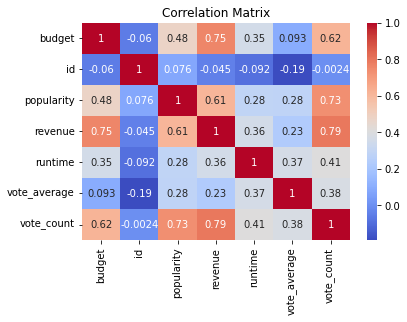

In [14]:
# Visualize the correlation between variables
corr_matrix = movies.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

(-1.25, 1.25, -1.25, 1.25)

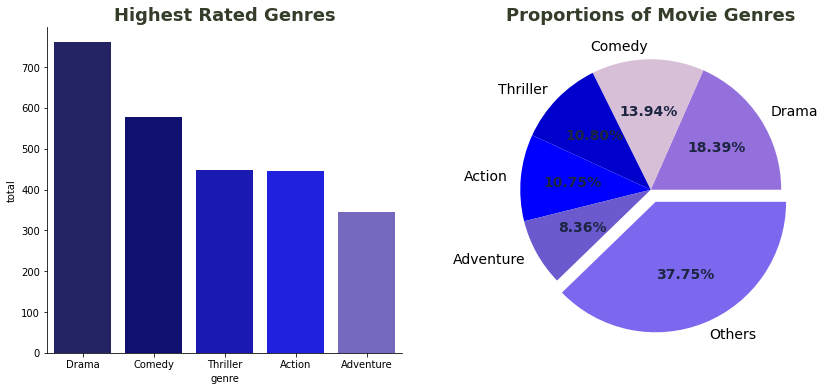

In [15]:
# Visualize the top genres
genres_list = []
for i in movies['genres']:
    genres_list.extend(i.split(', '))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

df_plot = pd.DataFrame(Counter(genres_list).most_common(5), columns=['genre', 'total'])
ax = sns.barplot(data=df_plot, x='genre', y='total', ax=axes[0], palette=['midnightblue', 'navy', 'mediumblue', 'blue', 'slateblue'])
ax.set_title('Highest Rated Genres', fontsize=18, weight=600, color='#333d29')
sns.despine()

df_plot_full = pd.DataFrame([Counter(genres_list)]).transpose().sort_values(by=0, ascending=False)
df_plot.loc[len(df_plot)] = {'genre': 'Others', 'total':df_plot_full[6:].sum()[0]}
plt.title('Proportions of Movie Genres', fontsize=18, weight=600, color='#333d29')
wedges, texts, autotexts = axes[1].pie(x=df_plot['total'], labels=df_plot['genre'], autopct='%.2f%%',
                                       textprops=dict(fontsize=14), explode=[0,0,0,0,0,0.1], colors=['mediumpurple', 'thistle', 'mediumblue', 'blue', 'slateblue', 'mediumslateblue'])

for autotext in autotexts:
    autotext.set_color('#1c2541')
    autotext.set_weight('bold')

axes[1].axis('off')
